In [2]:
import gymnasium as gym
import torch

import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import deque
import copy
from torch.autograd import Variable

import numpy as np
from collections import namedtuple

import torchvision.transforms as T
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.cuda.is_available()

True

In [4]:
DEVICE

device(type='cuda')

In [5]:
env = gym.envs.make("PongDeterministic-v4")

In [6]:
state_shape = env.observation_space.shape
n_action = env.action_space.n
print(state_shape)
print(n_action)
print(env.unwrapped.get_action_meanings()) 

(210, 160, 3)
6
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [7]:
ACTIONS = [0, 2, 3]
n_action = 3

In [8]:
image_size = 84
transform = T.Compose( [T.ToPILImage(),
                        T.Grayscale(num_output_channels=1),
                        T.Resize((image_size, image_size), interpolation=Image.BICUBIC),
                        T.ToTensor(),
                        ])

In [9]:
def get_state(obs):
    state = obs.transpose((2, 0, 1))
    state = torch.from_numpy(state)
    state = state.to(DEVICE)
    state = transform(state)
    return state

In [10]:

class DQN():
    def __init__(self, n_state, n_action, n_hidden, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, n_hidden[0]),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden[0], n_hidden[1]),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden[1], n_action)
                        )
        self.model = self.model.to(DEVICE)
        self.model_target = copy.deepcopy(self.model)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        # s: состояние
        # y: целевое значение
        y_pred = self.model(torch.tensor(s, device=DEVICE))
        loss = self.criterion(y_pred, Variable(torch.tensor(y, device=DEVICE)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        #      s: входное состояние
        # return: значения Q для всех действий
        with torch.no_grad():
            return self.model(torch.tensor(s, device=DEVICE, requires_grad=True))
        
    def target_predict(self, s):
        """
        Вычисляет значения Q-функции состояния для всех действий с помощью целевой сети
        @param s: входное состояние
        @return: целевые ценности состояния для всех действий
        """
        with torch.no_grad():
            return self.model_target(torch.tensor(s, device=DEVICE, requires_grad=True))

    def replay(self, memory, replay_size, gamma):
        """
        Воспроизведение опыта с целевой сетью
        @param memory: буфер воспроизведения опыта
        @param replay_size: количество выбираемых из буфера примеров при
        каждом обновлении модели
        @param gamma: коэффициент обесценивания
        """
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)
            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state.tolist())
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state).detach()
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                td_targets.append(q_values)
            self.update(states, td_targets)

    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())

    def save(self, file_name):
        torch.save(self.model_target, file_name)

In [11]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
        return torch.argmax(q_values).item()
    return policy_function

In [12]:
def q_learning(env, estimator, n_episode, replay_size, total_reward_episode, memory, target_update=10, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Глубокое Q-обучение с применением DDQN и буфера воспроизведения опыта
    @param env: имя окружающей среды Gym
    @param estimator: объекта класса DQN
    @param replay_size: сколько примеров использовать при каждом
    обновлении модели
    @param target_update: через сколько эпизодов обновлять целевую сеть
    @param n_episode: количество эпизодов
    @param gamma: коэффициент обесценивания
    @param epsilon: параметр ε-жадной стратегии
    @param epsilon_decay: коэффициент затухания epsilon
    """
    for episode in tqdm(range(n_episode)):
        if episode % target_update == 0:
            estimator.copy_target()
        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
        obs, _ = env.reset()
        state = get_state(obs).view(image_size * image_size)
        is_done = False
        is_break = False
        while not is_done and not is_break:
            action = policy(state)
            next_obs, reward, is_done, is_break, _ = env.step(ACTIONS[action])
            total_reward_episode[episode] += reward
            next_state = get_state(next_obs).view(image_size * image_size)
            memory.append((state, action, next_state, reward, is_done or is_break))
            if is_done:
                break
            estimator.replay(memory, replay_size, gamma)
            state = next_state
        #print('Эпизод: {}, полное вознаграждение: {}, epsilon:{}'.format(episode, total_reward_episode[episode], epsilon))
        epsilon = max(epsilon * epsilon_decay, 0.01)

In [13]:
n_state = image_size * image_size
n_hidden = [200, 50]
n_episode = 1000
lr = 0.003
replay_size = 32
target_update = 10
dqn = DQN(n_state, n_action, n_hidden, lr)
memory = deque(maxlen=10000)
total_reward_episode = [0] * n_episode
q_learning(env, dqn, n_episode, replay_size, total_reward_episode, memory, target_update, gamma=.9, epsilon=1)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\v.tyumenev\AppData\Local\Temp\ipykernel_10904\1632284201.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.model(torch.tensor(s, device=DEVICE, requires_grad=True))
C:\Users\v.tyumenev\AppData\Local\Temp\ipykernel_10904\1632284201.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.model_target(torch.tensor(s, device=DEVICE, requires_grad=True))
  0%|          | 1/1000 [00:57<15:57:02, 57.48s/it]


KeyboardInterrupt: 

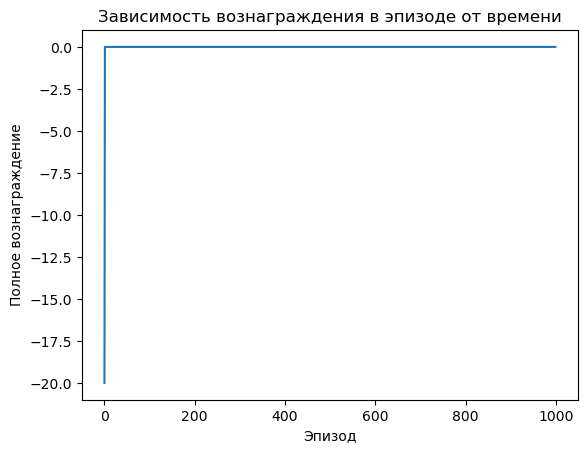

In [14]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [15]:
last_episode = 100

reward_end_episode = total_reward_episode[-last_episode:]
sum(reward_end_episode)/last_episode

0.0

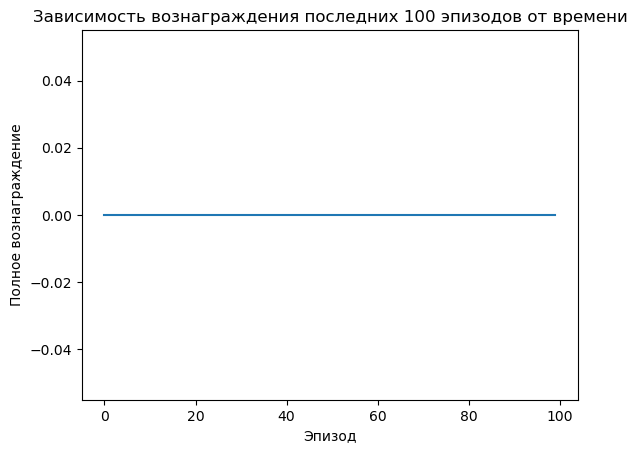

In [16]:
plt.plot(reward_end_episode)
plt.title('Зависимость вознаграждения последних {} эпизодов от времени'.format(last_episode))
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()